# **Image Blurrer Exercise**

This will be a simple exercise to load images into the memory, blur the images, and then displaying them. We will use OpenCV to help with the job. OpenCV is pre-installed in the Colab environment, so we don't have to install it.

## **Uploading Images to Colab for this Experiment**

To get started, we need some images, which you can manually upload from your PC. To do that, click on the `upload' icon as shown below.

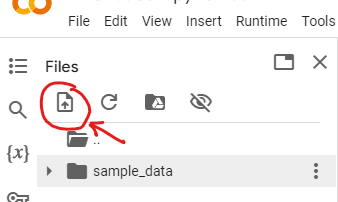


## **Download Images From the Web**

You can also download images from the web. The following `wget` commands download 3 images from the web. You can add more if you wish.

In [1]:
# Get images from the web
!wget https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg -O lena.jpeg
!wget https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg -O rose.jpg
!wget --user-agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36" https://images.pexels.com/photos/1054666/pexels-photo-1054666.jpeg -O elephant_large.jpg

--2025-01-06 17:16:55--  https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg
Resolving cdn2.techbang.com (cdn2.techbang.com)... 3.165.102.81, 3.165.102.110, 3.165.102.25, ...
Connecting to cdn2.techbang.com (cdn2.techbang.com)|3.165.102.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90069 (88K) [image/jpeg]
Saving to: ‘lena.jpeg’

lena.jpeg           100%[===================>]  87.96K  --.-KB/s    in 0.004s  

2025-01-06 17:16:55 (23.2 MB/s) - ‘lena.jpeg’ saved [90069/90069]

--2025-01-06 17:16:55--  https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347213 (339K) [image/jpeg]
Saving to: ‘rose.jpg’

rose.jpg            100%[===================>] 

## **Overcoming Limitation of Colab**

There is a slight problem displaying images in Colab. Most OpenCV functions work just fine under Colab. However, Colab does not allow easy way to display images unless the OpenCV program is written in Python language and execute directly in the cell. But, in this exercise, we want to write an OpenCV program in the C++ language. One way to overcome this is by first saving the images into files in whatever image format you desired and then manually open the images one by one to observe the result.

In this exercise, we want to display the images directly from C++ program. To do this, we will use an interprocess communication protocol called `named pipe` by setting up the channel between the C++ program and a Python code running in the cell. Whenever, the C++ wants to display an image, it sends the image through the pipe and the Python code receives and then displays it. We need a C++ stub and a Python stub, which act as proxies between our program in C++ and Python.

## **C++ Stub**

The following is the C++ stub, called `cv_pipe` that needs to be compiled together with the C++ program needing the service. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [2]:
# Header file for cv_pipe
%%writefile cv_pipe.h
#pragma once
#include <opencv2/opencv.hpp>
#include <iostream>
#include <string>
#include <unistd.h> // For pipe
#include <fcntl.h>  // For O_WRONLY

#define reset_getopt()    (optind = 0)

int cv_imshow(cv::Mat &image);
int init_cv_pipe_comm(int argc, char *argv[], bool verbose=false,           \
                                              bool mute_error=false);
int finalize_cv_pipe_comm();

void display_option_error(int optopt, std::string error_msg);
int get_integer(const char *optarg, int min, int max);

Writing cv_pipe.h


In [3]:
%%writefile cv_pipe.cpp
#include <boost/algorithm/string.hpp>
#include "cv_pipe.h"

static int fd = -1;

void display_option_error(int optopt, std::string error_msg) {
    std::cerr << "Error: option -" << static_cast<char>(optopt)             \
              << " " << error_msg << ".\n";
}

int get_integer(const char *optarg, int min, int max) {
    std::stringstream str;
    std::string arg(optarg);
    boost::trim(arg);
    bool error = false;
    int val;
    try {
        val = std::stoi(optarg);
        if(val < min || val > max)
            error = true;
    } catch (const std::invalid_argument& e) {
        error = true;
    }
    if(error) {
        str << "expects a number between " << min << " and " << max
            << ", but was given `" << arg << "`";
        throw std::invalid_argument(str.str());
    }
    return val;
}

int open_named_pipe(char *pipe_name) {
    fd = open(pipe_name, O_WRONLY);
    if(fd < 0) {
        std::cerr << "Error: failed to open the named pipe: "
                  << pipe_name << std::endl;
    }
    return fd;
}

int cv_imshow(cv::Mat &image) {
    if(fd < 0) {
        std::cerr << "Error: no named pipe available." << std::endl;
        return -1;
    }
    // Send image size as a header
    int img_size[3] = {image.cols, image.rows, image.channels()};
    write(fd, img_size, sizeof(img_size));
    // Send the image data
    write(fd, image.data, image.total() * image.elemSize());
    return 0;
}

int init_cv_pipe_comm(int argc, char *argv[], bool verbose, bool mute_error) {
    int opt;
    char *pipe_path = NULL;

    if(verbose) {
        // Print all input arguments
        for(int i = 0; i < argc; i++) {
            std::cout << "[" << i << "] " << argv[i] << std::endl;
        }
    }
    // Mute the option error if mute_error is true
    if(mute_error)
        opterr = 0;       // Do not print error to stderr
    while ((opt = getopt(argc, argv, ":p:")) != -1) {
        switch(opt) {
            case 'p':
                pipe_path = optarg;
                break;
            case ':':
                if(static_cast<char>(optopt) == 'p') {
                    display_option_error(optopt, "requires an argument");
                    return -1;
                }
                break;
            case '?':
                // Ignore all unknown options; let the main program handles it.
                break;
        }
    }
    if(!pipe_path) {
        std::cerr << "Error: expect a pipe name but none found. Try the "
                  << "following:\n\t" << argv[0] << " -p my_pipe\n";
        return -1;
    }

    fd = open_named_pipe(pipe_path);
    return fd;
}

int finalize_cv_pipe_comm() {
    close(fd);        // Close the write end of the pipe
    return 0;
}

Writing cv_pipe.cpp


## **Python Stub**

The following is the Python stub, called `runner` that we need to invoke the compiled C++ program and help display the images sent by the C++ program. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [4]:
%%writefile runner.py
import os, sys, subprocess
import threading
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def tee_pipe(pipe, out):
    for line in pipe:
        #print(line.decode('utf-8'), end='')
        #print(line.decode('utf-8'), end='',  file=out)
        out.write(line.decode('utf-8'))

def execute(filename, *args, pipe_name='/tmp/my_pipe'):
    if not os.path.exists(pipe_name):
        os.mkfifo(pipe_name)

    # Start the subprocess. The -u option is to force the Python subprocess
    # to flush its output everytime it prints.
    proc = subprocess.Popen(
            [filename, '-p', pipe_name, *args],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
    )
    # Create threads to capture and print stdout and stderr
    t1 = threading.Thread(target=tee_pipe, args=(proc.stdout, sys.stdout))
    t2 = threading.Thread(target=tee_pipe, args=(proc.stderr, sys.stdout))
    t1.start()
    t2.start()

    with open(pipe_name, "rb") as pipe:
        while True:
            # Read the image size from the pipe
            # The 1st 4 byte is column size
            # The 2nd 4 byte is row size
            # The 3rd 4 byte is channel size
            img_header = pipe.read(12)
            if not img_header:
                break
            image_size = np.frombuffer(img_header, dtype=np.uint32)
            # Read the image data for all channels
            frame_data = pipe.read(image_size[0] * image_size[1] * image_size[2])
            if not frame_data:
                break
            frame = np.frombuffer(frame_data, dtype=np.uint8).reshape((image_size[1], image_size[0], image_size[2]))
            # Display the received frame
            cv2_imshow(frame)

    proc.wait()                 # Wait for subprocess to exit
    os.remove(pipe_name)        # Clean up the named pipe
    cv2.destroyAllWindows()

Writing runner.py


## **Main Program of the Image Blurrer**

This is the main program of the image blurrer. Its role is to read image filenames and blur size from the user, load the images, and apply blur image processing on each image and output the images.  

In [5]:
%%writefile image_blurrer.cpp
#include <opencv2/opencv.hpp>
#include <iostream>
#include <string>
#include "cv_pipe.h"

void blur_image_core(uint8_t *blur_img, uint8_t *bgr_img,                     \
                                    int width, int height, int blur_size);

/**
 * Allocate memory for the out_img and then call the main function to blur the
 * image.
 */
cv::Mat &blur_image(cv::Mat &out_img, cv::Mat &in_img, int blur_size) {
    uint8_t* dData, *oData;
    int cols = in_img.cols, rows = in_img.rows;
    // Make sure that the unit data size is the same as uint8_t
    assert(in_img.elemSize() / in_img.channels() == sizeof(uint8_t));
    // Allocate memory for greyscale image (3 channels with each uint8_t)
    out_img.create(rows, cols, CV_8UC3);
    //Blur the image using CPU with blur_size of 1
    blur_image_core(out_img.data, in_img.data, cols, rows, blur_size);
    return out_img;
}

void display_help(int argc, char *argv[]) {
    std::cerr << "Usage: " << argv[0] << " [filename [, filename]]"         \
                  " <option>\n"                                             \
                  "Options:\n  -b <blur_size>    Set the blur size "        \
                  "in pixels in the range of [1, 100]\n";
}

int main(int argc, char *argv[]) {
    int error, opt;
    int blur_size = 2;                    // Default blur size to 2
    std::vector<char *> img_filenames;
    if((error = init_cv_pipe_comm(argc, argv, true, true)) < 0) return error;

    reset_getopt();
    while ((opt = getopt(argc, argv, "p:b:")) != -1) {
        switch (opt) {
            case 'p':
                // Do nothing because it should be handled by cv_pipe
                break;
            case 'b':         // Set the blur size
                try {
                    // Get the integer value from the option. Also, verify that
                    // it is between 1 and 100.
                    blur_size = get_integer(optarg, 1, 100);
                } catch (const std::invalid_argument& e) {
                    display_option_error(opt, e.what());
                    return -1;
                }
                break;
            case ':':
                // Handles option without input parameter from the user
                display_option_error(optopt, "requires an argument.");
                //display_help(argc, argv);
                return -1;
            case '?':
                std::cerr << "Error: unknown option -"
                          << static_cast<char>(optopt) << std::endl;
                display_help(argc, argv);
                return -1;
        }
    }
    // Get all filenames from the non-option arguments
    for (int index = optind; index < argc; index++)
        img_filenames.push_back(argv[index]);

    for(auto filename: img_filenames) {
        std::cout << filename << std::endl;
        // Load the filename image
        cv::Mat image = cv::imread(filename);
        if (image.empty()) {
            std::cerr << "Unable to load image\n";
            return -1;
        }
        cv::Mat blur_img;
        // Blur the image using the blur size specified by the user
        blur_img = blur_image(blur_img, image, blur_size);
        // Resize the image if its column is more than 1024 pixels before
        // displaying. You can remove it if you wish to display in its full
        // size. (Note: Colab will resize if it is too large to fit anyway.)
        const int MAX_SIZE = 1024;
        if(blur_img.cols > MAX_SIZE) {
            // Compute the ratio needed to shrink the columns to 1024 pixels
            float ratio = (float)MAX_SIZE / blur_img.cols;
            cv::resize(blur_img, blur_img, cv::Size(),                      \
                        ratio, ratio, cv::INTER_LINEAR);
        }
        cv_imshow(blur_img);
    }

    return finalize_cv_pipe_comm();
}

Writing image_blurrer.cpp


## **Blurring Image using CPU**

This is a fully functional blurring image core program using CPU. Study the code to help you in developing the same blurring effect using CUDA in the next part.

In [6]:
%%writefile cpu_image_blurrer.cpp
#include <iostream>

/**
 * Main code to blur the image running under CPU
 */
void blur_image_core(uint8_t *blur_img, uint8_t *bgr_img,
                                    int width, int height, int blur_size) {
    for(int y = 0; y < height; y++) {
        int y_ = y - blur_size;
        for(int x = 0; x < width; x++) {
            int intensity_sum[3] = {0, 0, 0};
            int count = 0, offset;
            // Find the (x_, y_) coordinate of all close vicinity neighbors
            for(int x_ = x - blur_size; x_ < x + blur_size; x_++) {
                for(int y_ = y - blur_size; y_ < y + blur_size; y_++) {
                    // Ensure that the neighbor exists
                    if(0 <= x_ && x_ < width && 0 <= y_ && y_ < height) {
                        // Compute the offset from the (x_, y_) coordinate
                        offset = (x_ + y_ * width) * 3;
                        // Add the intensity of each color of the close
                        // vicinity neighbor
                        intensity_sum[0] += bgr_img[offset++];    // Blue
                        intensity_sum[1] += bgr_img[offset++];    // Green
                        intensity_sum[2] += bgr_img[offset];      // Red
                        // Count the number of neighbors
                        count++;
                    }
                }
            }
            offset = (x + y * width) * 3;
            blur_img[offset++] = intensity_sum[0] / count;        // Blue
            blur_img[offset++] = intensity_sum[1] / count;        // Green
            blur_img[offset]   = intensity_sum[2] / count;        // Red
        }
    }
}

Writing cpu_image_blurrer.cpp


## **Compiling the Image Blurrer Program with G++**

This compiles the the code with G++ to be executed under the CPU.

In [7]:
!g++ -o cpu_image_blurrer cpu_image_blurrer.cpp image_blurrer.cpp cv_pipe.cpp `pkg-config --cflags --libs opencv4`

## **Run the Image Blurrer Program Under CPU**

Run the program under the CPU with a blur size of 6. Please try with different sizes to observe the effect.

[0] ./cpu_image_blurrer
[1] -p
[2] /tmp/my_pipe
[3] lena.jpeg
[4] rose.jpg
[5] -b 12
lena.jpeg
rose.jpg


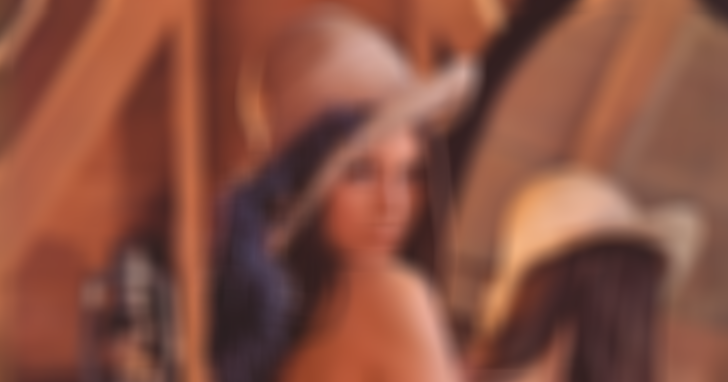

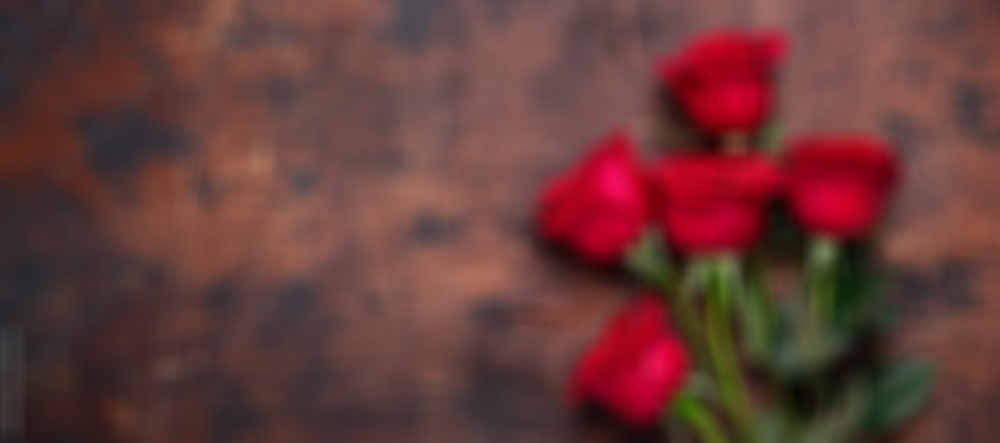

In [8]:
from runner import execute

execute(
    # Execute the program `cpu_image_blurrer` we compiled above
    "./cpu_image_blurrer",
    # Pass the images filenames downloaded from the web
    "lena.jpeg", "rose.jpg",
    # Uncomment the following image filename to test a larger image file
    # (Beware: large image takes long time to process especially when
    #          blur_size is huge)
    # "elephant_large.jpg",
    # Specify the blur size
    "-b 12",
)

## **Blurring Image using CUDA**

The following program is incomplete and it is an exercise for you to do the same blurring effect, but using CUDA. Write appropriate code statements below the comments highlighted.

In [9]:
%%writefile cuda_image_blurrer.cuh
#pragma once

#ifdef __CUDACC__
__global__ void blur_image_kernel(uint8_t *gray_img, uint8_t *bgr_img,        \
                                    int width, int height, int channels);
#endif

void blur_image_core(uint8_t *blur_img, uint8_t *bgr_img,                     \
                                    int width, int height, int blur_size);

Writing cuda_image_blurrer.cuh


Original Program (Exercise)

In [10]:
%%writefile cuda_image_blurrer.cpp
#include <iostream>
#include <cuda_runtime.h>
//#include <cuda.h>
//#include <device_launch_parameters.h>
#include "cuda_image_blurrer.cuh"

/**
 * The kernel implementating the blur_image processing in CUDA
 */
__global__ void blur_image_kernel(uint8_t *blur_img, uint8_t *bgr_img,
                                    int width, int height, int blur_size) {
    // Compute the linear index values for x and y
    // ...

    // Blur the image. Note that each pixel is handled by one thread
    // ...
}

const int thread_per_blk = 32;      // Use 32 threads per block for x and y
void blur_image_core(uint8_t *blur_img, uint8_t *bgr_img,
                                    int width, int height, int blur_size) {
    uint8_t* iData;                 // Input image data for device
    uint8_t* oData;                 // Output image data for device

    // Compute the image data size (hint: use width and height; note that
    // the pixel size is 1 byte, and remember that each pixel has 3 colors)
    const size_t dataSize = 0;          // Modify to the correct size

    // Allocate the device memory for iData and oData the size of `dataSize`
    // ...

    // Transfer BGR image from host to device memory.
    // ...

    // Calculate the blocksize and gridsize using the given `thread_per_blk`.
    // ...

    // Call the CUDA blur image kernel
    // ...

    // Transfer the output (processed) image from device to host memory.
    // ...

    // Free all the device memory
    // ...
}

Writing cuda_image_blurrer.cpp


Solution Program

In [14]:
%%writefile cuda_image_blurrer.cpp
#include <iostream>
#include <cuda_runtime.h>
//#include <cuda.h>
//#include <device_launch_parameters.h>
#include "cuda_image_blurrer.cuh"

/**
 * The kernel implementating the blur_image processing in CUDA
 */
__global__ void blur_image_kernel(uint8_t *blur_img, uint8_t *bgr_img,
                                    int width, int height, int blur_size) {
    // Compute the linear index values for x and y
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;

    // Blur the image. Note that each pixel is handled by one thread
    if (x < width && y < height){
      int pixel_idx = (y * width + x) * 3; // Each pixel has 3 components (BGR)

      int sum_b = 0, sum_g = 0, sum_r = 0;
      int num_neighbors = 0;

      for (int i = -blur_size; i <= blur_size; i++){
        for (int j = -blur_size; j <= blur_size; j++){
          int neighbor_x = x + i;
          int neighbor_y = y + j;

          if (neighbor_x >= 0 && neighbor_x < width && neighbor_y >= 0 && neighbor_y < height){
            int neighbor_index = (neighbor_y * width + neighbor_x) * 3;

            sum_b += bgr_img[neighbor_index];
            sum_g += bgr_img[neighbor_index + 1];
            sum_r += bgr_img[neighbor_index + 2];

            num_neighbors++;
          }
        }
      }

      blur_img[pixel_idx] = sum_b / num_neighbors;
      blur_img[pixel_idx + 1] = sum_g / num_neighbors;
      blur_img[pixel_idx + 2] = sum_r / num_neighbors;
    }
}

const int thread_per_blk = 32;      // Use 32 threads per block for x and y
void blur_image_core(uint8_t *blur_img, uint8_t *bgr_img,
                                    int width, int height, int blur_size) {
    uint8_t* iData;                 // Input image data for device
    uint8_t* oData;                 // Output image data for device

    // Compute the image data size (hint: use width and height; note that
    // the pixel size is 1 byte, and remember that each pixel has 3 colors)
    const size_t dataSize = width * height * 3 * sizeof(uint8_t);          // Modify to the correct size

    // Allocate the device memory for iData and oData the size of `dataSize`
    cudaMalloc((void**)&iData, dataSize);
    cudaMalloc((void**)&oData, dataSize);

    // Transfer BGR image from host to device memory.
    cudaMemcpy(iData, bgr_img, dataSize, cudaMemcpyHostToDevice);

    // Calculate the blocksize and gridsize using the given `thread_per_blk`.
    dim3 blockSize(thread_per_blk, thread_per_blk);
    dim3 gridSize((width + thread_per_blk - 1) / thread_per_blk,
              (height + thread_per_blk - 1) / thread_per_blk);

    // Call the CUDA blur image kernel
    blur_image_kernel <<<gridSize, blockSize>>> (oData, iData, width, height, blur_size);

    // Transfer the output (processed) image from device to host memory.
    cudaMemcpy(blur_img, oData, dataSize, cudaMemcpyDeviceToHost);

    // Free all the device memory
    cudaFree(iData);
    cudaFree(oData);
}

Writing cuda_image_blurrer.cpp


## **Renaming the Filename and Compiling the CUDA Program**

The `cuda_image_blurrer.cpp` is renamed to `cuda_image_blurrer.cu` so that NVCC compiler will correctly compile the CUDA program into the GPU assembly language.

In [15]:
!mv cuda_image_blurrer.cpp cuda_image_blurrer.cu
!nvcc -o cuda_image_blurrer image_blurrer.cpp cuda_image_blurrer.cu cv_pipe.cpp `pkg-config --cflags --libs opencv4`

## **Run the Image Blurrer Program Under CUDA**

Run the program under CUDA with a blur size of 6. Please try with different sizes to observe the effect. Notice the speed difference compared to the plain CPU processsing. The large image of the elephant is being processsed at faster speed, even with a large blur size (try with a blur size of 15).

[0] ./cuda_image_blurrer
[1] -p
[2] /tmp/my_pipe
[3] lena.jpeg
[4] rose.jpg
[5] -b 12
lena.jpeg
rose.jpg


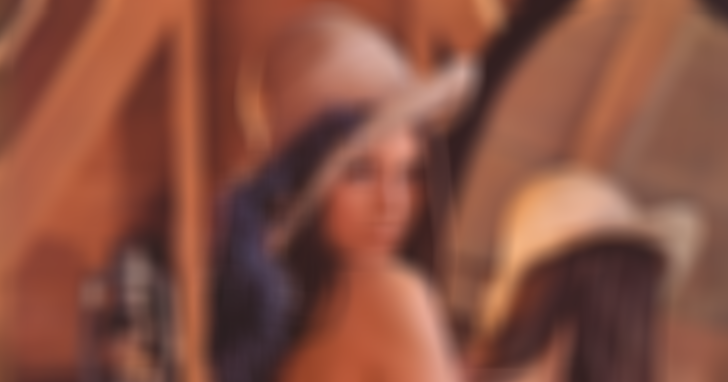

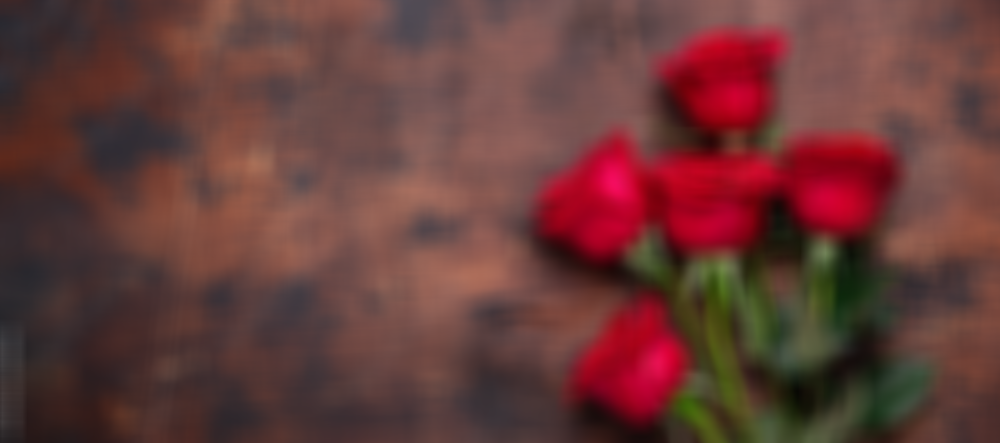

In [16]:
from runner import execute

execute(
    # Execute the program `cpu_image_blurrer` we compiled above
    "./cuda_image_blurrer",
    # Pass the images filenames downloaded from the web
    "lena.jpeg", "rose.jpg",
    # Comment out the following image filename to avoid testing a larger image
    # file. Note however that the GPU runs very much faster for this large
    # image, even with a very large blur size.
    # "elephant_large.jpg",
    # Specify the blur size
    "-b 12",
)